## Fraud Detection

Fraud is a billion-dollar business that expands massively year by year. 

A lot of people fall victim to it despite the awareness organisations try to raise. 

Fraud always includes a false statement, misinterpretation, or deceitful conduct. 

Common varieties of fraud offenses include identity theft, insurance fraud, credit/debit card fraud, and mail fraud.

## Payment type

Putting fraud under control is really an issue particularly for the financial and commerce industry. The number of transactions has increased due to a variety of online payment options, such as credit or debit cards, smartphones payment applications, online payment sites, etc. At the same time, cybercriminals have become adept at finding and exploiting ambiguities or inadequacy of the online payment systems. As a result, it is getting tougher for businesses to authenticate and approve transactions.

## Import Libraries

In [1]:
pip install Keras

In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

In [4]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
from keras.layers import Input, Dense
from keras import regularizers
from tensorflow.python import tf2
from keras import distribute
from keras import models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

## Looking at the Data

In [7]:
df = pd.read_csv('Online Payment Fraud Detection.csv',encoding='unicode-escape')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [8]:
df.shape

(1048575, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 80.0+ MB


We can see that all the features in the dataset are numerical features and there are no null values present in the dataset. So we will not have to perform null-value handling on this dataset.

## Exploratory Data Analysis of the Online Fraud Dataset

In [10]:
df.type.value_counts()

CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: type, dtype: int64

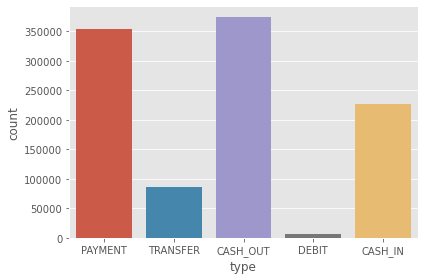

In [11]:
fig,ax=plt.subplots(figsize=(6,4))
ax=sns.countplot(x='type', data=df)
plt.tight_layout()

As we can see from this countplot, the cashout and payment are the highest type of online transaction

In [12]:
df['isFraud'].describe()

count    1.048575e+06
mean     1.089097e-03
std      3.298351e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: isFraud, dtype: float64

In [13]:
odd=df.isFraud.value_counts()
odd

0    1047433
1       1142
Name: isFraud, dtype: int64

In [14]:
ratio_cases = odd/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.0010890971079798775
Ratio of non-fraudulent cases: 0.9989109028920201


<AxesSubplot:>

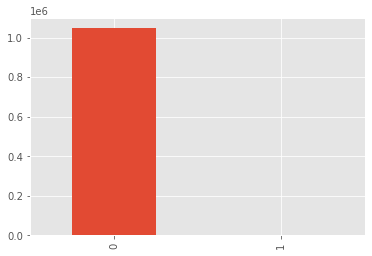

In [15]:
df.isFraud.value_counts().plot.bar()

Fraudulent transactions are only a 0.1% of total transaction.
The ratio of fraudulent transactions is very low. This is a case of class imbalance problem.
It can be seen from the above visualization that the bar chat does not clearly depict the distributuion of non fradulent and fraudulent transaction, hence we will use another visualization tool.

In [16]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.isFraud.values
    return X, y

In [17]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="isFraud #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="isFraud #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [18]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

In [19]:
df.groupby('type').isFraud.describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_IN,227130,0,0,0,0,0,0,0
CASH_OUT,373641,0,0,0,0,0,0,1
DEBIT,7178,0,0,0,0,0,0,0
PAYMENT,353873,0,0,0,0,0,0,0
TRANSFER,86753,0,0,0,0,0,0,1


In [20]:
df.groupby('isFraud').isFraud.describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,1047433,0,0,0,0,0,0,0
1,1142,1,0,1,1,1,1,1


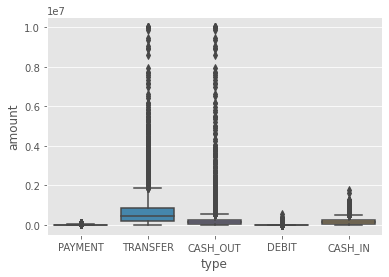

In [21]:
sns.boxplot(x='type', y='amount', data=df)
plt.show()

It is observed that there are a lot of outliers in our data, so therefore, meaningful insights cannot be drawn from the amount that was transacted.


In [22]:
pivot = df.groupby(['type','isFraud']).amount.mean().astype(int).unstack('isFraud')
#display the pivot
pivot

isFraud,0,1
type,,
CASH_IN,169923.0,NaN
CASH_OUT,182500.0,1177134.0
DEBIT,5878.0,NaN
PAYMENT,11122.0,NaN
TRANSFER,630647.0,1208507.0


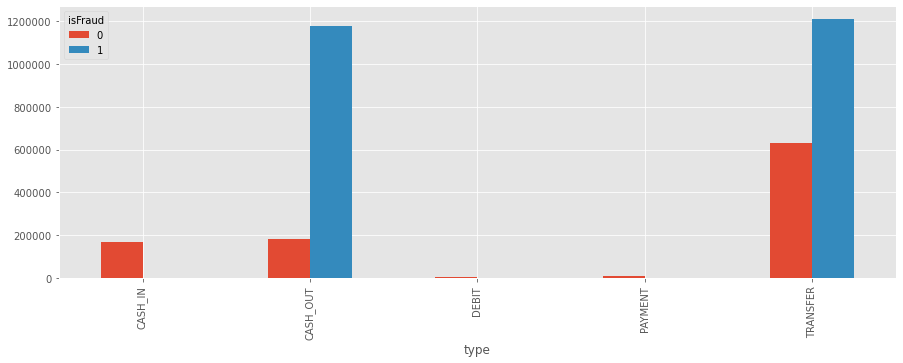

In [23]:
pivot.plot.bar(figsize=(15,5))
plt.ticklabel_format(style='plain',axis='y') 

plt.show()

From this analysis, it shows Cash out and Transfer transactions had the highest fradulent activities while cash in,debit, and payment had no fradulent activity to it.

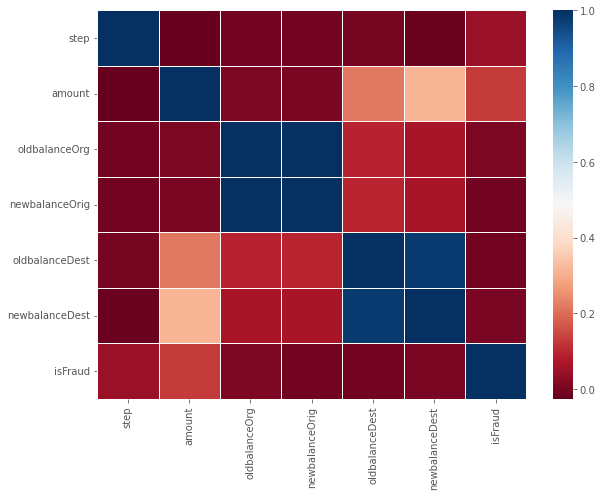

In [24]:
corr = df.corr()
fig, ax=plt.subplots(figsize=(9,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=1,cmap="RdBu", ax=ax)
plt.tight_layout()

As we can see from the above, there is a;
1. Strong correlation between the balance before the transaction and the balance after the transaction.
2. Strong correlation between the initial balance of receipient after the transaction and the new balance of receipient after the transaction
3. Absolutely no correlation between a fraudulent transaction and any of the variables displayed above. This means that any amount of money can be hacked not neccesarily large or small amounts.


## Encoding Feature Engineering

ML Based Systems
1. Adapt to the data, thus can change over time
2. Uses all the data combined, rather than a threshold per feature
3. Produces a probability, rather than a binary score
4. Typically have better performance and can be combined with rules

In [25]:
df.drop('nameOrig', axis=1,inplace=True)
print(df)

         step      type     amount  oldbalanceOrg  newbalanceOrig  \
0           1   PAYMENT    9839.64      170136.00       160296.36   
1           1   PAYMENT    1864.28       21249.00        19384.72   
2           1  TRANSFER     181.00         181.00            0.00   
3           1  CASH_OUT     181.00         181.00            0.00   
4           1   PAYMENT   11668.14       41554.00        29885.86   
...       ...       ...        ...            ...             ...   
1048570    95  CASH_OUT  132557.35      479803.00       347245.65   
1048571    95   PAYMENT    9917.36       90545.00        80627.64   
1048572    95   PAYMENT   14140.05       20545.00         6404.95   
1048573    95   PAYMENT   10020.05       90605.00        80584.95   
1048574    95   PAYMENT   11450.03       80584.95        69134.92   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  
0        M1979787155            0.00            0.00        0  
1        M2044282225            0.00       

In [26]:
df.drop('nameDest', axis=1,inplace=True)
print(df)

         step      type     amount  oldbalanceOrg  newbalanceOrig  \
0           1   PAYMENT    9839.64      170136.00       160296.36   
1           1   PAYMENT    1864.28       21249.00        19384.72   
2           1  TRANSFER     181.00         181.00            0.00   
3           1  CASH_OUT     181.00         181.00            0.00   
4           1   PAYMENT   11668.14       41554.00        29885.86   
...       ...       ...        ...            ...             ...   
1048570    95  CASH_OUT  132557.35      479803.00       347245.65   
1048571    95   PAYMENT    9917.36       90545.00        80627.64   
1048572    95   PAYMENT   14140.05       20545.00         6404.95   
1048573    95   PAYMENT   10020.05       90605.00        80584.95   
1048574    95   PAYMENT   11450.03       80584.95        69134.92   

         oldbalanceDest  newbalanceDest  isFraud  
0                  0.00            0.00        0  
1                  0.00            0.00        0  
2                 

In [27]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [28]:
df.replace('PAYMENT','1',inplace=True)
df.replace('TRANSFER','2',inplace=True)
df.replace('CASH_OUT','3',inplace=True)
df.replace('DEBIT','4',inplace=True)
df.replace('CASH_IN','5',inplace=True)

In [29]:
y = df['isFraud']

In [30]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

In [31]:
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [47]:

feature_columns = ['amount', 'type', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest']

In [48]:
X = df[feature_columns]

In [49]:

X.head()

,amount,type,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,9839.64,1,170136.0,160296.36,0.0,0.0
1,1864.28,1,21249.0,19384.72,0.0,0.0
2,181.00,2,181.0,0.00,0.0,0.0
3,181.00,3,181.0,0.00,21182.0,0.0
4,11668.14,1,41554.0,29885.86,0.0,0.0


## Decision Tree 

1. Machine  learning  techniques  are  applied  in  many               areas  of  research  for  deriving  computational  intelligence.  It allows for  the  generalization  of  specific  examples  that can  be used in modelling, predication, and classification of datasets.

2. A decision  tree  is  one  such  widely  used  machine  learning technique that has been effective for classification or regression. Its usefulness results from the ability to compensate for missing values and having a highly flexible hypothesis space. 

3. Decision trees are generated by algorithms that split a dataset into multiple branching segments based on decision rules. These decision  rules  are  determined  by  identifying  a  relationship between input attributes and  the outputs. 

4. In this model, Regression algorithms are used to predict future values based on previously  learned  data.  The  key  goal  of  applying  the  M5P decision  tree  algorithm  in  this  problem  space  is  to  learn individual  behavior  per  costumer  to  create  an  online fraud  model. 

5. Afterwards,  the  online fraud  model  is  used  to  predict  future  customer behaviours. With the ability to predict future fraudulent behaviour, it is possible to compare  the  real  values  with  the  predicted  values  and  apply statistical measures to detect potential fraudulent activities

In [50]:
from sklearn.tree import DecisionTreeRegressor

In [51]:
df_DTR = DecisionTreeRegressor(random_state=42)

In [52]:
df_DTR.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [53]:
preds = df_DTR.predict(X)

In [54]:
print('Actual Fraud:', y.head().tolist())
print('Predicted Fraud:', preds[:5])

Actual Fraud: [0, 0, 1, 1, 0]
Predicted Fraud: [0. 0. 1. 1. 0.]


In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [57]:
print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

X_train:  (734002, 6)
X_test:  (314573, 6)
y_train:  (734002,)
y_test:  (314573,)


In [58]:
X_train.head()

,amount,type,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
420027,470715.18,3,0.00,0.00,675499.00,1166866.26
575892,124048.10,5,1975301.88,2099349.97,179847.30,55799.20
994900,74964.94,3,30867.00,0.00,279748.49,354713.43
179258,17443.42,1,0.00,0.00,0.00,0.00
830114,2109.82,1,0.00,0.00,0.00,0.00


In [59]:
X_test.head()

,amount,type,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
475138,15494.53,1,0.00,0.00,0.00,0.00
641856,80051.11,3,0.00,0.00,2384477.51,2613117.67
449655,25859.15,5,2755511.29,2781370.44,388103.54,362244.39
713172,97006.77,3,0.00,0.00,1039152.20,1136158.97
4236,162541.79,3,0.00,0.00,327229.36,99535.40


In [61]:
#retrain model

df_DTR.fit(X_train,y_train)

#predict on the test data
preds2 = df_DTR.predict(X_test)


In [62]:
print(y_test.head().tolist())
print(preds2[:5])

[0, 0, 0, 0, 0]
[0. 0. 0. 0. 0.]


In [63]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y,preds)
print(mae)

0.0


This means that on average, the difference between the true fraud and our prediction is 0. Very Accurate

In [64]:
#get mean absolute error

mae2 = mean_absolute_error(y_test,preds2)

print('Without splitting',mae)
print('With splitting',mae2)

Without splitting 0.0
With splitting 0.00039736404586534764


## Random Forest Regressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

df_RF_model = RandomForestRegressor()

In [ ]:
#fit your model on the training data
df_RF_model.fit(X_train, y_train)

In [ ]:
#predict on test data
preds_RF = df_RF_model.predict(X_test)

In [ ]:
#manually compare

print(y_test.head().tolist())
print(preds_RF[:5])

In [ ]:
#calculate error
mae_RF = mean_absolute_error(y_test,preds_RF)

print('Decision tree with train test split: ',mae2)
print('Random Forest with train test split: ',mae_RF)

In [ ]:
pd.Series(preds_RF).astype(int).head()